<a href="https://colab.research.google.com/github/bcury/Machine-Learning-Projects/blob/main/ML_Detec%C3%A7%C3%A3o_Fraudes_Redes_Neurais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [10]:
base_dados = pd.read_csv('/content/creditcard.csv')

In [11]:
base_dados.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
base_dados.shape

(284807, 31)

In [13]:
base_dados.isnull().values.any()

False

In [14]:
base_dados.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

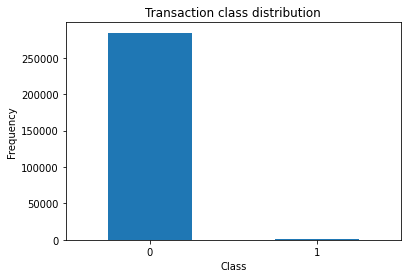

In [17]:
count_classes = pd.value_counts(base_dados['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xlabel("Class")
plt.ylabel("Frequency");

A classe 0 representa representa sem fraude, já a classe 1 rpresenta fraude

In [21]:
fraude = base_dados[base_dados.Class == 1]
sem_fraude = base_dados[base_dados.Class == 0]
fraude.shape

(492, 31)

In [22]:
sem_fraude.shape

(284315, 31)

In [23]:
fraude.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [24]:
sem_fraude.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

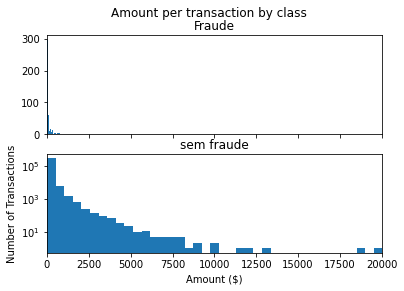

In [27]:
#representação gráfica

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(fraude.Amount, bins = bins)
ax1.set_title('Fraude')

ax2.hist(sem_fraude.Amount, bins = bins)
ax2.set_title('sem fraude')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

quando ocorrem mais os fraudes?

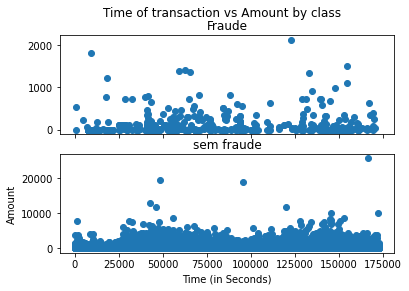

In [30]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraude.Time, fraude.Amount)
ax1.set_title('Fraude')

ax2.scatter(sem_fraude.Time, sem_fraude.Amount)
ax2.set_title('sem fraude')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

bom, não parece que teve muita relevância com os gráficos acima

**Treinamento e previsão**

In [31]:
from sklearn.preprocessing import StandardScaler
data = base_dados.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [33]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=0)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

In [34]:
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

In [35]:
X_train = X_train.values
X_test = X_test.values

In [36]:
X_train.shape

(227454, 29)

In [37]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [38]:
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [39]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7108/7108 [==============================] - 16s 2ms/step - loss: 0.8190 - accuracy: 0.5765 - val_loss: 0.8329 - val_accuracy: 0.6263
Epoch 2/100
7108/7108 [==============================] - 15s 2ms/step - loss: 0.7424 - accuracy: 0.6449 - val_loss: 0.7930 - val_accuracy: 0.6694
Epoch 3/100
7108/7108 [==============================] - 14s 2ms/step - loss: 0.7198 - accuracy: 0.6812 - val_loss: 0.7834 - val_accuracy: 0.6725
Epoch 4/100
7108/7108 [==============================] - 14s 2ms/step - loss: 0.7136 - accuracy: 0.6899 - val_loss: 0.7778 - val_accuracy: 0.6948
Epoch 5/100
7108/7108 [==============================] - 15s 2ms/step - loss: 0.7100 - accuracy: 0.6943 - val_loss: 0.7738 - val_accuracy: 0.6940
Epoch 6/100
7108/7108 [==============================] - 14s 2ms/step - loss: 0.7074 - accuracy: 0.6978 - val_loss: 0.7717 - val_accuracy: 0.7018
Epoch 7/100
7108/7108 [==============================] - 14s 2ms/step - loss: 0.7056 - accuracy: 0.7006 - val_loss: 0.7704 -

In [40]:
autoencoder = load_model('model.h5')

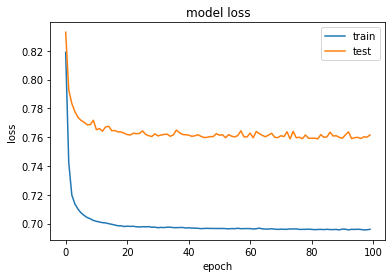

In [41]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

vamos dar uma olhada mais profunda nas distribuições dos erros

In [42]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_base_dados = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_base_dados.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.757982,0.001773
std,7.264675,0.042071
min,0.045375,0.000000
25%,0.243729,0.000000
50%,0.394462,0.000000
75%,0.621541,0.000000
max,1523.407024,1.000000


Reconstruindo o erro sem fraude

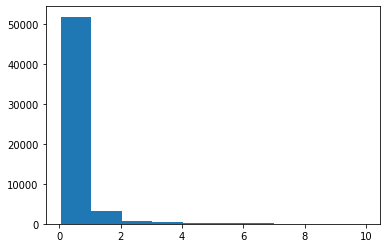

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
sem_fraude_error_base_dados = error_base_dados[(error_base_dados['true_class']== 0) & (error_base_dados['reconstruction_error'] < 10)]
_ = ax.hist(sem_fraude_error_base_dados.reconstruction_error.values, bins=10)

Recnstruindoo erro com fraude

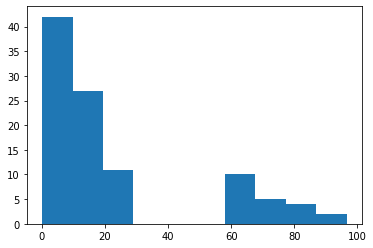

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraude_error_base_dados = error_base_dados[error_base_dados['true_class'] == 1]
_ = ax.hist(fraude_error_base_dados.reconstruction_error.values, bins=10)

In [46]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curvas são muito uteis

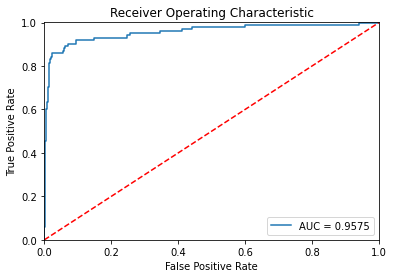

In [47]:
fpr, tpr, thresholds = roc_curve(error_base_dados.true_class, error_base_dados.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

A curva ROC representa a taxa de verdadeiro positivo versus a taxa de falso positivo, em diferentes valores de limite. Basicamente, queremos que a linha azul fique o mais próximo possível do canto superior esquerdo. Embora nossos resultados pareçam muito bons, devemos ter em mente a natureza de nosso conjunto de dados. ROC não parece muito útil para nós nesse caso, então, vamos seguir

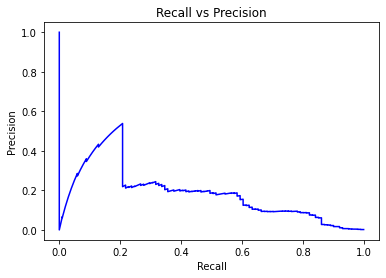

In [48]:
precision, recall, th = precision_recall_curve(error_base_dados.true_class, error_base_dados.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Uma área alta sob a curva representa alta rechamada e alta precisão, em que alta precisão se relaciona a uma taxa baixa de falsos positivos e alta rechamada está relacionada a uma baixa taxa de falsos negativos. Altas pontuações para ambos mostram que o classificador está retornando resultados precisos (alta precisão), bem como retornando a maioria de todos os resultados positivos (alta recuperação)

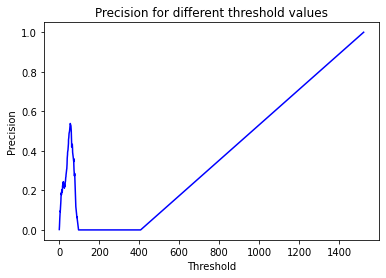

In [49]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Você pode ver que, à medida que o erro de reconstrução aumenta, nossa precisão também aumenta. Vamos dar uma olhada no recall:

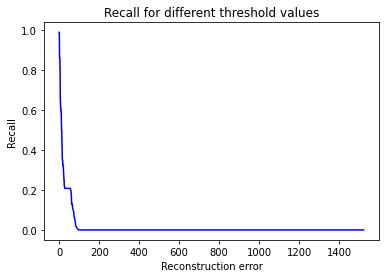

In [50]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Aqui, temos a situação exatamente oposta. À medida que o erro de reconstrução aumenta, a recuperação diminui

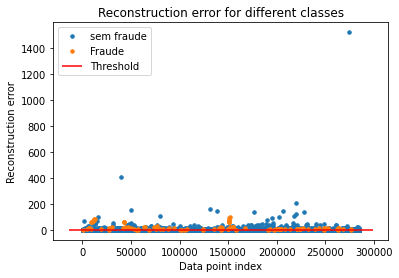

In [51]:
#Previsão

threshold = 2.9

groups = error_base_dados.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraude" if name == 1 else "sem fraude")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

Esse gráfico pode ser um pouco enganador. Vamos dar uma olhada na matriz de confusão:

In [ ]:
y_pred = [1 if e > threshold else 0 for e in error_base_dados.reconstruction_error.values]
conf_matrix = confusion_matrix(error_base_dados.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels= labels, yticklabels= labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

[ 55491 ....................1373 ; 
.
.
.
  20..........................78 ]

construimos um bom modelo que preve muito bem a maioria dos fraudes

foi usado um modelo simples de Deep Autoencoder em Keras

Fonte: Kaggle